# About

Theoretical plots of the analysis pertaining to the N-dimensional Kuramoto system with adaptive delays. Does not require any exported numerical simulations from MATLAB scripts.

Uses the following packages and functions:

funlib:
 - Omega_infty

rootlib:
 - find_root
 
eigenlib:
 - eig_infty_scale
 - eig_infty_poly

# Library

In [1]:
from __future__ import division, print_function

%matplotlib inline
# Toggle on/off
# %matplotlib notebook

import os
import numpy as np
import scipy.io as sio
from scipy import optimize
import matplotlib.pyplot as plt
import matplotlib.transforms as tsfm
import math
from math import pi

from lib import *

from IPython.display import clear_output

# Generate arrays to plot

## Parameters

In [2]:
g = 1.5
omega0 = w0 = 1.0
gain = 50
tau0 = 0.1

# Parameter dictionary
param = {'g': g,
         'omega0': omega0,
         'gain': gain,
         'tau0': tau0
         }

# Settings
Omega_range = g
delta_range = 0.5

part_Omega = 200
part_delta = 200

steps = 200

Omega_cap = 0.5
eig_cap = 1

# Generate error meshes
Omega_arr = np.linspace(w0 - Omega_range, w0 + Omega_range, num=part_Omega)
delta_arr = np.linspace(0, delta_range, num=part_delta)
Omega_mesh, delta_mesh = np.meshgrid(Omega_arr, delta_arr)

## Synchronization states

### Full error mesh

In [3]:
# Fixed-point functions
Omega_fun = lambda Omega, delta2: funlib.Omega_infty(Omega, delta2, param, L=2*pi, steps=steps) - Omega
# Omega_fun_asy = lambda Omega, delta2: eigenlib.Omega_infty_asy(Omega, delta2, param, deg_sin=50) - Omega

# Processing function
z_fun = lambda x: x

# Generate error mesh
err_mesh = np.zeros(Omega_mesh.shape)

for j in range(delta_arr.size):
    for k in range(Omega_arr.size):
        new_err = Omega_fun(Omega_mesh[j,k], delta_mesh[j,k]**2)
        err_mesh[j,k] = np.max((np.min((new_err, Omega_cap)), -Omega_cap))
    
z_mesh = z_fun(err_mesh)
# z_mesh = z_mesh / np.abs(z_mesh).max()

# Set the limits of the plot to the limits of the data
z_bound = np.abs(z_mesh).max()

### Error arrays and solution curve

In [4]:
# Generate arrays for Omega w.r.t. fixed delta:
delta_list = [0.05, 0.1, 0.2, 0.4]
z_arrs = {}

# For each delta_list, obtain corresponding Omega array:
for delta0 in delta_list:
    ind = np.argmin(np.abs(delta_arr - delta0))
    z_arrs[ind] = z_mesh[ind,:]
    
# Obtain Omega = Omega(delta) function
Omega_roots = np.zeros(delta_arr.size+1)
Omega_roots[0] = w0

for k in range(delta_arr.size):
    deltak = delta_arr[k]
    Omega_funk = lambda Omega: Omega_fun(Omega, deltak**2)
    new_root = rootlib.find_root(Omega_funk, Omega_roots[k], w0-g, w0+g, steps=100)
    if new_root[1]:
        Omega_roots[k+1] = new_root[0]

Omega_roots = Omega_roots[1:]

## Eigenvalues

### Polynomial roots

In [5]:
# Numerical options
steps = 400
L = 2*pi
deg = 3
R = 10

delta_list_eig = [0.07, 0.08, 0.09, 0.1]
delta_list_inds = []
for delta1 in delta_list_eig:
    delta_list_inds.append(np.argmin(np.abs(delta_arr - delta1)))

eig_roots_dict = {}

# Terms of eigenvalue polynomial
eig_terms_fun = lambda u,v2: eigenlib.eig_infty_poly(deg, u, v2, param, R=R, L=L, steps=steps)

stab_arr = np.zeros(Omega_roots.size)
stab_mesh = np.zeros(delta_mesh.shape)

for j in range(delta_arr.size):
    
    # Obtain solution curve:
    Omega0 = Omega_roots[j]
    eig_coeffs0 = eig_terms_fun(Omega0, delta_arr[j]**2)
    eig_roots0 = np.roots(eig_coeffs0)
    eig_roots0 = eig_roots0[np.abs(eig_roots0) > 1e-8]
    
    if eig_roots0.size == 0:
        max_real0 = 0
    else:
        max_real0 = np.max(np.real(eig_roots0))

    stab_arr[j] = np.sign(max_real0)*np.log(1 + np.abs(max_real0))

    # Save all eigenvalues if in delta_list_eig:
    if j in delta_list_inds:
        eig_roots_dict[delta_arr[j+1]] = eig_roots0
            
            
    for k in range(Omega_arr.size):
        
        # Get eigenvalue polynomial coefficients
        eig_coeffs = eig_terms_fun(Omega_mesh[j,k], delta_mesh[j,k]**2)
        
        # Get roots of eigenvalue polynomial (remove all zeros)
        eig_roots = np.roots(eig_coeffs)
        eig_roots = eig_roots[np.abs(eig_roots) > 1e-14]
        
        if eig_roots.size == 0:
            max_real = 0
        else:
            max_real = np.max(np.real(eig_roots))
        
        stab_entry = np.max((np.min((max_real, 1)), -1))
        stab_mesh[j,k] = stab_entry

Omega_min = Omega_arr.min()
Omega_max = Omega_arr.max()
delta_min = delta_arr[1:].min()
delta_max = delta_arr[1:].max()

# Plot

## Plot options

In [10]:
# Plot positions [left, bottom, width, height] 
bbox0 = [0.1, 0.5, 0.30, 0.3]  # Fig 3a: Error plots with fixed delta2
bbox1 = [0.5, 0.5, 0.35, 0.3] # Fig 3b: Solution curve of synchronization state + stability colour plot
bbox2 = [0.9, 0.5, 0.05, 0.3] # Fig 3b: Colour bar for stability colour plot
bbox3 = [0.1, 0.1, 0.30, 0.3] # Fig 3c: Stability along solution curve
bbox4 = [0.5, 0.1, 0.35, 0.3] # Fig 3d: Stability along solution curve

alpha = 0.9
levels = np.linspace(-1, 1, 4, endpoint=True)

# Plot options
lw_ab1 = 1.8
lw_ab2 = 0.8
lw_cd = 0.5
ms_c = 30

al_ab = 1.0
al_cd = 0.8

# Axis lines
eig_options_line = {'linestyle': 'dashed',
                    'linewidth': 0.5,
                    'color': 'white'
                    }

sol_colour = 'blue'
colour_list = ['red', 'magenta', 'orange', 'olive']
colour_list2 = ['blue', 'green', 'orange', 'red']

## Generate figure

delta = 0.05025125628140704
delta = 0.10050251256281408
delta = 0.20100502512562815
delta = 0.39949748743718594


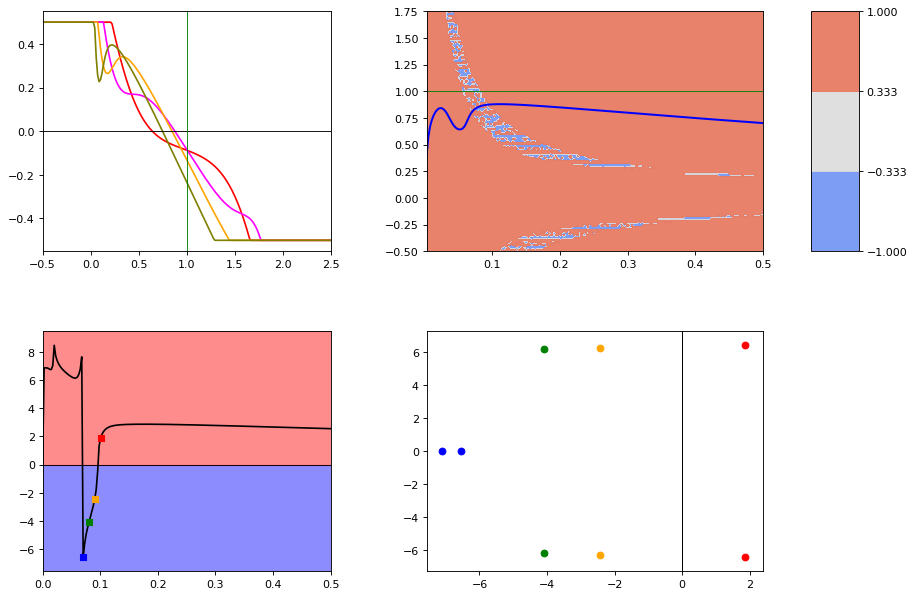

In [11]:
fig, ax = plt.subplots(5, figsize=(12,10), dpi=80)

# Set positions
ax[0].set_position(bbox0)
ax[1].set_position(bbox1)
ax[2].set_position(bbox2)
ax[3].set_position(bbox3)
ax[4].set_position(bbox4)

# Plot arrays

# Figure 3a
j = 0
for key in z_arrs.keys():
    ax[0].plot(Omega_arr, z_arrs[key], color=colour_list[j])
    print('delta = ' + str(delta_arr[key]))
    j += 1

ax[0].axhline(y=0, color='black', linewidth=lw_ab2)
ax[0].axvline(x=omega0, color='green', linewidth=lw_ab2)
ax[0].set_xlim(left=Omega_arr.min(), right=Omega_arr.max())

# Figure 3b
c = ax[1].contourf(delta_mesh, Omega_mesh, np.sign(stab_mesh), levels, cmap='coolwarm', alpha=alpha)
ax[1].axis([delta_min, delta_max, Omega_min, Omega_max])

ax[1].plot(delta_arr, Omega_roots, color=sol_colour, linewidth=lw_ab1)
ax[1].axhline(y=omega0, color='green', linewidth=lw_ab2)

ax[1].set_ylim(bottom=omega0-g, top=omega0+g/2)
fig.colorbar(c, cax=ax[2])


# Figure 3c

# Colour regions
dummy_x = np.array([omega0-g, omega0+g/2])
ax[3].fill_between(dummy_x, stab_arr.min()-1, 0, alpha=alpha/2, color='blue')
ax[3].fill_between(dummy_x, 0, stab_arr.max()+1, alpha=alpha/2, color='red')

ax[3].plot(delta_arr, stab_arr, color='black', zorder=1)


ax[3].set_xlim(left=delta_arr.min(), right=delta_arr.max())
ax[3].set_ylim(bottom=stab_arr.min()-1, top=stab_arr.max()+1)

# Frequency line
ax[3].axhline(y=0, color='black', linewidth=lw_ab2)


# Figure 3d
k = 0
for key in eig_roots_dict.keys():
    eig_re = np.real(eig_roots_dict[key])
    eig_im = np.imag(eig_roots_dict[key])
    
    eig_log_re = np.sign(eig_re)*np.log(1 + np.abs(eig_re))
    eig_log_im = np.sign(eig_im)*np.log(1 + np.abs(eig_im))
    ax[4].scatter(eig_log_re, eig_log_im, color=colour_list2[k])
    
    ax[4].axvline(x=0, color='black', linewidth=lw_ab2)
    
    # Markers
    ind_k = delta_list_inds[k]
    ax[3].scatter(np.array([delta_arr[ind_k]]), np.array([stab_arr[ind_k]]), 
                  s=ms_c, marker='s', color=colour_list2[k], zorder=2)
    k += 1

In [8]:
np.concatenate((np.zeros(1), np.reshape(stab_inds,-1)))

NameError: name 'stab_inds' is not defined